Goal: This script adds an adaptive pooling layer to [this](https://github.com/arvindkrishna87/STAT390_WI2025/blob/a90ac97e593db9953ff84f22a33382476c8faeb6/Presentation%205/Coders/Nathan%20Jung/CNN%20model.ipynb) CNN model made last quarter by Nathan and evaluates how the model performs relative to the model without an adaptive pooling layer.

Author: David Gormley

Last Modified: 5/13/25

Structure

1) Import Dependencies and mount drive

2) Train Model

3) Evaluate Model

4) Adjust Threshold

Key Issue
- Folder is missing some of the cases that Krish identified as good cases
    - Here are the cases Krish identified as good
      - train_cases  = [2,1,22,9,34,38,53,55,78,62,85,89,21,3,45,49]
      - test_cases   = [77,60,79,70,90,92,25,12]

    - Here are the cases that we actually have
      - true_train = [1,2,3,9,53,55,78,85,89]
      - true_test = [12,60,77,79,90,92]



**1) Import Dependencies and mount drive**

In [ ]:
# stdlib
import os
import glob
import re
import struct
from concurrent.futures import ThreadPoolExecutor, as_completed

# data & imaging
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader

# torchvision
import torchvision
from torchvision import transforms

# metrics & plotting
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Colab
from google.colab import drive

In [ ]:
# ─── 1) MOUNT GOOGLE DRIVE ──────────────────────────────────────────────
drive.mount('/content/drive', force_remount=True)

# ─── 2) DEVICE & CUDNN ──────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cudnn.benchmark = True  # auto‐tune for fixed input sizes

Mounted at /content/drive


**2. Train Model**
- We can adjust the following
    - Restricting image size: min and max image width used for training and evaluation
    - Stain type
    - Train and test cases

Loaded metadata from /content/drive/MyDrive/patch_metadata.csv


<ipython-input-28-9ac20a93a717>:351: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda')) # Enable scaler only for CUDA


Using device: cpu
Number of training images: 804
Number of testing images: 633


Epoch 1/10:   0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-28-9ac20a93a717>:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')): # Enable autocast only for CUDA
Epoch 1/10: 100%|██████████| 30/30 [01:15<00:00,  2.51s/it, loss=3.0298]


Epoch 1 Avg Loss: 3.0298


Epoch 2/10: 100%|██████████| 30/30 [01:08<00:00,  2.28s/it, loss=0.5348]


Epoch 2 Avg Loss: 0.5348


Epoch 3/10: 100%|██████████| 30/30 [01:10<00:00,  2.36s/it, loss=0.3583]


Epoch 3 Avg Loss: 0.3583


Epoch 4/10: 100%|██████████| 30/30 [01:09<00:00,  2.33s/it, loss=0.2498]


Epoch 4 Avg Loss: 0.2498


Epoch 5/10: 100%|██████████| 30/30 [01:10<00:00,  2.35s/it, loss=0.2497]


Epoch 5 Avg Loss: 0.2497


Epoch 6/10: 100%|██████████| 30/30 [01:08<00:00,  2.29s/it, loss=0.2231]


Epoch 6 Avg Loss: 0.2231


Epoch 7/10: 100%|██████████| 30/30 [01:09<00:00,  2.31s/it, loss=0.1849]


Epoch 7 Avg Loss: 0.1849


Epoch 8/10: 100%|██████████| 30/30 [01:10<00:00,  2.34s/it, loss=0.1636]


Epoch 8 Avg Loss: 0.1636


Epoch 9/10: 100%|██████████| 30/30 [01:15<00:00,  2.52s/it, loss=0.2283]


Epoch 9 Avg Loss: 0.2283


Epoch 10/10: 100%|██████████| 30/30 [01:17<00:00,  2.58s/it, loss=0.1455]


Epoch 10 Avg Loss: 0.1455


Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]<ipython-input-28-9ac20a93a717>:411: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
Evaluating: 100%|██████████| 25/25 [00:38<00:00,  1.55s/it]


Best threshold for Accuracy: 0.380 (Accuracy = 0.8973)
Best threshold for F1-Score: 0.380 (F1-Score = 0.9017)

Metrics using F1-optimized threshold (t=0.380):
Accuracy:  0.8973
Precision: 0.8869
Recall:    0.9169
F1 Score:  0.9017


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (4).

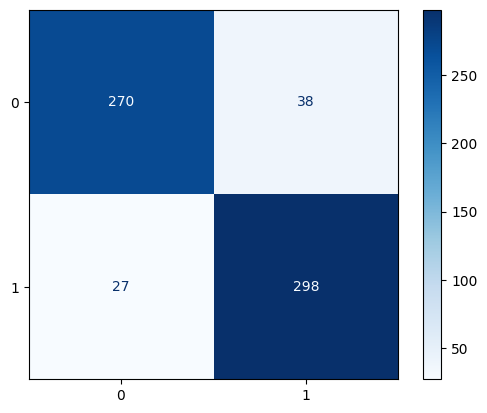

In [ ]:
import os
import re
import struct
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import transforms, models
from torchvision.transforms import functional as VisionF # Renamed to avoid conflict
from torchvision.transforms.functional import pad
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# ─── A) HELPER: RESIZE LARGE IMAGES ──────────────────────────────────────
class ResizeIfLarge:
    def __init__(self, max_side=400):
        self.max_side = max_side
    def __call__(self, img):
        w, h = img.size
        if max(w, h) > self.max_side:
            scale = self.max_side / max(w, h)
            return VisionF.resize(img, (int(h*scale), int(w*scale)))
        return img

# ─── B) HELPER: BUCKET BATCH SAMPLER ─────────────────────────────────────
class BucketBatchSampler(Sampler):
    def __init__(self, data_source_sizes, batch_size, boundaries, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle

        bucket_indices = {i: [] for i in range(len(boundaries) + 1)}
        for idx, size in enumerate(data_source_sizes):
            bucket_num = sum(size > b for b in boundaries) # Determine bucket number
            bucket_indices[bucket_num].append(idx)

        self.batches = []
        for bucket_num in sorted(bucket_indices.keys()): # Process buckets in order for reproducibility if shuffle is False
            indices_in_bucket = bucket_indices[bucket_num]
            if self.shuffle:
                np.random.shuffle(indices_in_bucket)

            for i in range(0, len(indices_in_bucket), batch_size):
                batch = indices_in_bucket[i:i+batch_size]
                if len(batch) > 0: # Ensure batch is not empty
                    self.batches.append(batch)

        if self.shuffle:
            np.random.shuffle(self.batches) # Shuffle the order of batches

    def __iter__(self):
        return iter(self.batches)

    def __len__(self):
        return len(self.batches)

# ─── C) HELPER: MAKE BUCKET BOUNDARIES ───────────────────────────────────
def make_boundaries_from_sizes(sizes, n_buckets):
    if not sizes:
        return []
    if n_buckets <= 1:
        return []
    qs = [100 * i / n_buckets for i in range(1, n_buckets)]
    bounds = np.percentile(sizes, qs)
    return sorted(list(set(int(b) for b in bounds))) # Ensure unique, sorted boundaries

# ─── D) HELPER: GET IMAGE SIZES FOR BUCKETING ────────────────────────────
def get_image_post_resize_max_dims(paths_list, path_to_dims_map, max_side_transform_limit):
    sizes = []
    valid_paths = []
    for p in paths_list:
        w, h = path_to_dims_map.get(p, (-1, -1))

        if w <= 0 or h <= 0:
            try:
                with Image.open(p) as temp_img: # Use 'with' to ensure file is closed
                    w_actual, h_actual = temp_img.size
                current_max_dim = max(w_actual, h_actual)
            except (UnidentifiedImageError, FileNotFoundError, OSError, Exception) as e:
                # print(f"Warning: Could not determine dimensions for {p}. Error: {e}. Skipping.")
                continue
        else:
            current_max_dim = max(w, h)

        if current_max_dim > max_side_transform_limit:
            sizes.append(max_side_transform_limit)
        else:
            sizes.append(current_max_dim)
        valid_paths.append(p)
    return sizes, valid_paths

# ─── 1) CONFIG ──────────────────────────────────────────────────────────
image_folder   = "/content/drive/MyDrive/'25 Spring/390/CMIL_SP2025_Patches_Apr27"
train_cases    = [92,78,55,60,49,45,38,53,9,22,77,79,70]
test_cases     = [34,1,99,62,89,2,12,90,21,3,85,25,98]
all_cases      = set(train_cases + test_cases)
batch_size     = 32
num_workers    = 2
lr             = 1e-3
num_epochs     = 10
min_width, max_width = 50, 10000
meta_csv       = '/content/drive/MyDrive/patch_metadata.csv' # Stores results of build_metadata
labels_csv     = "/content/drive/MyDrive/'25 Spring/390/case_grade_match.csv" # For labels
force_rebuild_metadata = False # Set to True to rescan image folder
device         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_resize_side = 512 # Max side for ResizeIfLarge transform
n_buckets      = 10   # Number of buckets for bucketing

# ─── 2) LOAD LABELS ──────────────────────────────────────────────────────
try:
    labels_df = pd.read_csv(labels_csv)
    # Original code had: .drop(index=64, errors='ignore').reset_index(drop=True)
    # Ensure this is still relevant for your labels_csv
    if 64 in labels_df.index: # Safely drop if index 64 exists
         labels_df = labels_df.drop(index=64, errors='ignore')
    labels_df = labels_df.reset_index(drop=True)

    class_map = {int(r.Case): (0 if r.Class==1 else 1) for _,r in labels_df.iterrows()}
except FileNotFoundError:
    print(f"Error: Labels CSV not found at {labels_csv}")
    exit()
except Exception as e:
    print(f"Error loading labels: {e}")
    exit()

# ─── 3) METADATA ─────────────────────────────────────────────────────────
case_pat = re.compile(r'case_0*(\d+)_(?:match|unmatched)_', re.IGNORECASE)

def fast_scan(root):
    for e in os.scandir(root):
        if e.is_file() and e.name.endswith('.png'):
            yield e.path
        elif e.is_dir():
            yield from fast_scan(e.path)

def build_metadata():
    if os.path.exists(meta_csv) and not force_rebuild_metadata:
        try:
            df = pd.read_csv(meta_csv)
            if {'path','case_number','stain','width','height'}.issubset(df.columns):
                print(f"Loaded metadata from {meta_csv}")
                return df
        except pd.errors.EmptyDataError:
            print(f"Warning: Metadata file {meta_csv} is empty. Rebuilding.")
        except Exception as e:
            print(f"Warning: Could not properly read {meta_csv}. Error: {e}. Rebuilding.")


    print(f"Building metadata by scanning {image_folder}...")
    files = list(fast_scan(image_folder))
    if not files:
        print(f"Error: No PNG files found in {image_folder}. Please check the path.")
        exit()

    def proc(p):
        m = case_pat.search(os.path.basename(p))
        if not m: return None
        cid = int(m.group(1))
        # Only process cases that are in train_cases or test_cases and have labels
        if cid not in all_cases or cid not in class_map: return None

        stain = 'h&e' if 'h&e' in p.lower() else None # Assuming 'h&e' in path indicates stain
        if not stain: return None # Filter out non-h&e stains if necessary

        w,h = -1,-1
        try:
            # Attempt to read PNG dimensions quickly from header
            with open(p,'rb') as f:
                hdr = f.read(24)
            if len(hdr)>=24 and hdr.startswith(b'\x89PNG\r\n\x1a\n') and hdr[12:16] == b'IHDR':
                w = struct.unpack('>I',hdr[16:20])[0]
                h = struct.unpack('>I',hdr[20:24])[0]
            else: # Fallback if not a standard PNG or header read fails
                try:
                    with Image.open(p) as img_pil:
                        w, h = img_pil.size
                except (UnidentifiedImageError, FileNotFoundError, OSError):
                    pass # w,h remain -1
        except Exception:
            pass # w,h remain -1
        return {'path':p,'case_number':cid,'stain':stain,'width':w,'height':h}

    with ThreadPoolExecutor(max_workers=num_workers if num_workers > 0 else os.cpu_count()) as exe: # Use num_workers for executor
        rows = list(tqdm(exe.map(proc, files), total=len(files), desc="Scanning image files"))

    df = pd.DataFrame([r for r in rows if r])
    if df.empty:
        print("Error: No valid image metadata could be built. Check paths, case numbers, and file types.")
        exit()

    df.to_csv(meta_csv, index=False)
    print(f"Metadata built and saved to {meta_csv}")
    return df

df_meta = build_metadata()

# Filter metadata:
# 1. Only cases in train_cases or test_cases (already partly handled in proc)
df_meta = df_meta[df_meta.case_number.isin(all_cases)]
# 2. Valid dimensions (width > min_width implicitly handles width > 0 if min_width > 0)
#    Height also needs to be positive.
df_meta = df_meta[
    ((df_meta.width > min_width) & (df_meta.width < max_width) & (df_meta.height > 0)) |
    ((df_meta.width == -1) & (df_meta.height == -1)) # Allow initially unknown, will try to load
]
df_meta = df_meta[df_meta.stain == 'h&e'] # Ensure H&E stain

df_train_meta = df_meta[df_meta.case_number.isin(train_cases)].copy() # Use .copy() to avoid SettingWithCopyWarning
df_test_meta  = df_meta[df_meta.case_number.isin(test_cases)].copy()

initial_train_paths = df_train_meta.path.tolist()
initial_test_paths  = df_test_meta.path.tolist()

# Precompute map from path to original w,h for efficiency
path_to_dims_map = {row['path']: (row['width'], row['height'])
                    for _, row in df_meta.iterrows()}

# Get image dimensions for bucketing (after considering ResizeIfLarge)
# This also filters out paths that are unreadable or have issues determining dimensions
train_max_dims, train_paths = get_image_post_resize_max_dims(initial_train_paths, path_to_dims_map, max_resize_side)
test_max_dims, test_paths = get_image_post_resize_max_dims(initial_test_paths, path_to_dims_map, max_resize_side)

if not train_paths:
    print("Error: No valid training images found after dimension checking. Exiting.")
    exit()
if not test_paths:
    print("Warning: No valid test images found after dimension checking.")
    # Depending on requirements, you might exit or just proceed without testing.
    # For now, we'll let it potentially create an empty test loader.

# Create bucket boundaries using training data sizes
train_boundaries = make_boundaries_from_sizes(train_max_dims, n_buckets)

# Create samplers
train_batch_sampler = BucketBatchSampler(train_max_dims, batch_size, train_boundaries, shuffle=True)
if test_max_dims: # Only create test sampler if there are test images
    test_batch_sampler = BucketBatchSampler(test_max_dims, batch_size, train_boundaries, shuffle=False) # Use train boundaries, no shuffle for test
else:
    test_batch_sampler = None

# ─── 4) TRANSFORMS ────────────────────────────────────────────────────────
train_transform = transforms.Compose([
    ResizeIfLarge(max_resize_side),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
test_transform = transforms.Compose([
    ResizeIfLarge(max_resize_side),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# ─── 5) DATASET & PAD-COLLATE ────────────────────────────────────────────
class CaseDataset(Dataset):
    def __init__(self, paths, cmap, transform):
        self.paths = paths # Already filtered valid paths
        self.cmap = cmap
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, i): # i is an index from BucketBatchSampler
        p = self.paths[i]
        try:
            img = Image.open(p).convert('RGB')
        except (UnidentifiedImageError, FileNotFoundError, OSError, Exception) as e:
            # This should ideally not happen often if paths are pre-filtered by get_image_post_resize_max_dims
            # print(f"Error opening image {p} in dataset: {e}. Returning None.")
            return None

        img = self.transform(img)

        match = case_pat.search(os.path.basename(p))
        if not match: # Should not happen if paths are from metadata
            return None
        cid = int(match.group(1))

        if cid not in self.cmap: # Case ID not in label map
            # print(f"Warning: Case ID {cid} for path {p} not found in class_map. Skipping.")
            return None
        lbl = self.cmap[cid]

        return img, lbl, cid

def collate_fn(batch):
    batch = [b for b in batch if b is not None] # Filter out None items from dataset __getitem__
    if not batch:
        return None, None, None # Return None if batch is empty after filtering

    imgs, lbls, cids = zip(*batch)

    H = max(img.shape[1] for img in imgs)
    W = max(img.shape[2] for img in imgs)

    padded_imgs = []
    for img in imgs:
        padding = (0, 0, W - img.shape[2], H - img.shape[1]) # left, top, right, bottom
        padded_imgs.append(pad(img, padding))

    return torch.stack(padded_imgs), torch.tensor(lbls, dtype=torch.long), torch.tensor(cids)


train_ds = CaseDataset(train_paths, class_map, train_transform)
train_loader = DataLoader(train_ds,
                          batch_sampler=train_batch_sampler, # Use batch_sampler
                          num_workers=num_workers,
                          pin_memory=True if device.type == 'cuda' else False, # pin_memory if cuda
                          collate_fn=collate_fn)

if test_paths and test_batch_sampler:
    test_ds = CaseDataset(test_paths, class_map, test_transform)
    test_loader = DataLoader(test_ds,
                             batch_sampler=test_batch_sampler, # Use batch_sampler
                             num_workers=num_workers,
                             pin_memory=True if device.type == 'cuda' else False,
                             collate_fn=collate_fn)
else:
    test_loader = None
    print("Test loader not created as there are no valid test images or sampler.")

# ─── 6) MODEL SETUP ─────────────────────────────────────────────────────
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT) # Use updated weights API
for p in model.parameters(): p.requires_grad=False

# Modify features to ensure output size compatibility with classifier
# AlexNet default output before classifier is (batch_size, 256, 6, 6)
# Adding AdaptiveAvgPool2d((6,6)) is redundant if the feature output is already 6x6.
# Let's confirm AlexNet's feature output size. It is indeed 256x6x6.
# So, the original model.features is fine, just need to ensure the classifier input matches.
# model.features = nn.Sequential(*list(model.features), nn.AdaptiveAvgPool2d((6,6))) # This is fine
in_ftrs = 256*6*6 # Correct for AlexNet

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5), # Standard dropout rates for AlexNet
    nn.Linear(in_ftrs, 4096), nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(inplace=True),
    nn.Linear(4096, len(labels_df['Class'].unique())) # Output layer size based on number of unique classes in CSV
)
model.to(device)
opt = optim.Adam(model.classifier.parameters(), lr=lr) # Only train classifier
crit = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda')) # Enable scaler only for CUDA
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True

# ─── 7) TRAIN ────────────────────────────────────────────────────────────
print(f"Using device: {device}")
print(f"Number of training images: {len(train_paths)}")
if test_paths:
    print(f"Number of testing images: {len(test_paths)}")
else:
    print("No testing images.")

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0; total_n = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=True) # leave=True
    for batch_data in pbar:
        if batch_data[0] is None: # Skip if collate_fn returned None due to empty batch
            continue
        imgs, lbls, _ = batch_data
        imgs, lbls = imgs.to(device), lbls.to(device)

        opt.zero_grad()
        with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')): # Enable autocast only for CUDA
            output = model(imgs)
            loss = crit(output, lbls)

        if device.type == 'cuda':
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        else: # For CPU
            loss.backward()
            opt.step()

        total_loss += loss.item()*imgs.size(0)
        total_n += imgs.size(0)
        if total_n > 0:
             pbar.set_postfix(loss=f"{total_loss/total_n:.4f}")
        else:
             pbar.set_postfix(loss="N/A")


    if total_n > 0:
        print(f"Epoch {epoch} Avg Loss: {total_loss/total_n:.4f}")
    else:
        print(f"Epoch {epoch} - No data processed.")


# ─── 8) EVAL + THRESHOLD SWEEP ───────────────────────────────────────────
if test_loader:
    model.eval()
    probs_list, labels_list = [], []
    with torch.no_grad():
        for batch_data in tqdm(test_loader, desc="Evaluating", leave=True):
            if batch_data[0] is None: # Skip if collate_fn returned None
                continue
            imgs, lbls, _ = batch_data
            imgs = imgs.to(device)

            with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
                logits = model(imgs)

            # Assuming binary classification, probs for the positive class (label 1)
            # The class_map is {Case: (0 if Class==1 else 1)}. So Class 1 -> label 0, Other Class -> label 1.
            # Softmax output will be [prob_for_label_0, prob_for_label_1]
            # We want probability of label 1.
            probs = torch.softmax(logits,dim=1)[:,1]
            probs_list.append(probs.cpu())
            labels_list.extend(lbls.cpu().tolist()) # Move labels to CPU before extending

    if not probs_list or not labels_list:
        print("No evaluation data processed or available.")
    else:
        probs = torch.cat(probs_list)
        labels = np.array(labels_list, dtype=int)

        # find threshold maximizing accuracy
        thresholds = torch.linspace(0,1,101) # 201 points for thresholds 0.000, 0.005, ..., 1.000
        best_acc, best_t_acc = 0, 0
        best_f1, best_t_f1 = 0, 0

        for t_val in thresholds:
            t = t_val.item()
            preds = (probs > t).int().numpy()
            acc = accuracy_score(labels, preds)
            f1 = f1_score(labels, preds, zero_division=0) # Handle zero division for F1

            if acc > best_acc:
                best_acc, best_t_acc = acc, t
            if f1 > best_f1:
                best_f1, best_t_f1 = f1, t

        print(f"Best threshold for Accuracy: {best_t_acc:.3f} (Accuracy = {best_acc:.4f})")
        print(f"Best threshold for F1-Score: {best_t_f1:.3f} (F1-Score = {best_f1:.4f})")

        # Use F1-optimized threshold for final metrics as it's often better for imbalanced classes
        final_preds = (probs > best_t_f1).int().numpy()
        print(f"\nMetrics using F1-optimized threshold (t={best_t_f1:.3f}):")
        print(f"Accuracy:  {accuracy_score(labels, final_preds):.4f}")
        print(f"Precision: {precision_score(labels, final_preds, zero_division=0):.4f}")
        print(f"Recall:    {recall_score(labels, final_preds, zero_division=0):.4f}")
        print(f"F1 Score:  {f1_score(labels, final_preds, zero_division=0):.4f}")

        cm = confusion_matrix(labels, final_preds)
        disp = ConfusionMatrixDisplay(cm, display_labels=[str(i) for i in range(len(labels_df['Class'].unique()))]) # Dynamic display labels
        disp.plot(cmap='Blues', values_format='d')
        plt.title(f"Confusion Matrix @ t={best_t_f1:.3f}")
        # Save the plot instead of showing if running in a non-interactive environment
        plt.savefig("confusion_matrix.png")
        print("Confusion matrix saved to confusion_matrix.png")
        # plt.show() # plt.show() might not work in all environments like Colab background tasks
else:
    print("Skipping evaluation as no test data is available.")

print("Script finished.")

**3) Evaluate Model**

In [ ]:
# ─── 9) PATCH‐LEVEL EVALUATION ───────────────────────────────────────────
model.eval()
all_preds, all_labels = [], []
correct, total = 0, 0

with torch.no_grad():
    # MODIFICATION: Unpack all three items from the test_loader
    for images, labels, case_ids in test_loader:
        # Handle potential None batch if using the collate_fn_skip_none
        if images is None: # Check images as a proxy for the whole batch being None
             # print("[WARN] Skipping an empty batch during evaluation.") # Uncomment for debugging
             continue # Skip this batch

        images, labels = (images.to(device, non_blocking=True),
                          labels.to(device, non_blocking=True))
        outputs = model(images)
        preds   = outputs.argmax(dim=1)

        # You were already collecting preds and labels correctly after this
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct += (preds == labels).sum().item()
        total   += labels.size(0) # Use labels.size(0) or preds.size(0) or images.size(0) for actual batch size

# The rest of your code for calculating metrics is correct
accuracy  = 100 * correct / total if total > 0 else 0 # Add check for total > 0
precision = precision_score(all_labels, all_preds)
recall    = recall_score(all_labels, all_preds)
f1        = f1_score(all_labels, all_preds)

print(f"Test Patch‐level Accuracy : {accuracy:.2f}%")
print(f"Precision                : {precision:.4f}")
print(f"Recall                   : {recall:.4f}")
print(f"F1 Score                 : {f1:.4f}")

print(f"Total test patches evaluated: {total}")
print(f"Correct predictions         : {correct}")

# Note: case_ids are available in the loop if you need them for per-patch analysis later,
# but they are not used in this specific patch-level metric calculation block.
# The per-case metrics calculation block you had previously *does* use case_ids.


In [ ]:
# ─── CONFUSION MATRIX ────────────────────────────────────────────────────
cm = confusion_matrix(all_labels, all_preds)
labels = ['Benign', 'High-grade']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

**4) Adjusting Threshold**

In [ ]:
model.eval()
probs, labels = [], []

with torch.no_grad():
    for batch in test_loader:
        if batch is None: continue
        imgs, lbls, _ = batch
        imgs = imgs.to(device)

        outputs = model(imgs)
        softmax_probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of class 1

        probs.append(softmax_probs.cpu())
        labels.extend(lbls)  # Python list is OK here

probs = torch.cat(probs)
labels = torch.tensor(labels)


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

thresholds = torch.linspace(0, 1, 201)
best_acc = 0
best_thresh = 0

for t in thresholds:
    preds = (probs > t).int().numpy()
    acc = accuracy_score(labels.numpy(), preds)
    if acc > best_acc:
        best_acc = acc
        best_thresh = t.item()

print(f"✅ Best threshold for accuracy: {best_thresh:.3f}")
print(f"🔍 Accuracy at best threshold: {best_acc:.4f}")


✅ Best threshold for accuracy: 0.380
🔍 Accuracy at best threshold: 0.8973


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert predictions and labels to NumPy arrays
final_preds = (probs > best_thresh).int().numpy()
true_labels = labels.numpy()


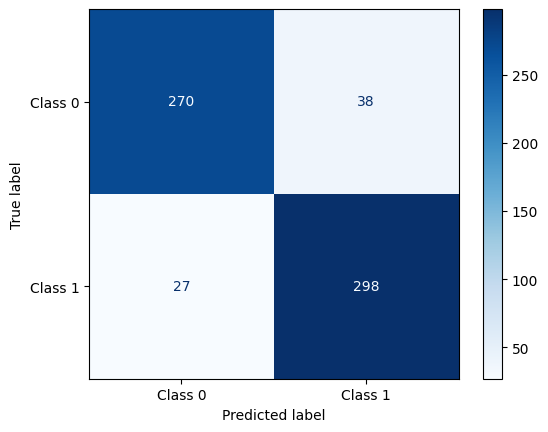

In [ ]:
cm = confusion_matrix(true_labels, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap='Blues', values_format='d')


Best Threshold: 0.38
Accuracy:  0.8973
Precision: 0.8869
Recall:    0.9169
F1 Score:  0.9017


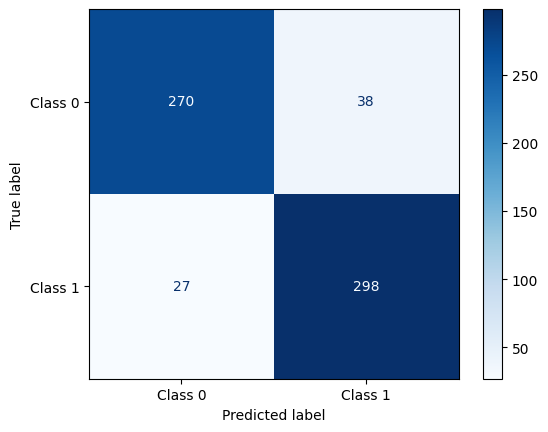

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Apply threshold
final_preds = (probs > best_thresh).int().numpy()
true_labels = labels.numpy()

# Step 2: Compute metrics
acc  = accuracy_score(true_labels, final_preds)
prec = precision_score(true_labels, final_preds, zero_division=0)
rec  = recall_score(true_labels, final_preds, zero_division=0)
f1   = f1_score(true_labels, final_preds, zero_division=0)

# Step 3: Print metrics
print(f"Best Threshold: {best_thresh:.2f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Step 4: Confusion matrix
cm = confusion_matrix(true_labels, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap='Blues', values_format='d')
